# Predicting Dementia Severity using Modifiable Risk Factors

## Setup

We begin by loading in all necessary packages, reading in the data, and defining helper functions.

In [113]:
    # Data libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import openpyxl
from scipy import stats
from scipy.stats import wilcoxon
    # Plotting libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from IPython.display import display, Latex

    # Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80
sns.color_palette("hls", 12)

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# sklearn modules
import sklearn
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import preprocessing as pp
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, RepeatedKFold, cross_validate, cross_val_score
from sklearn.linear_model import Ridge, ElasticNet, LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import f_regression, SequentialFeatureSelector
from sklearn.inspection import permutation_importance
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
#!pip install mlxtend
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [2]:
# Load data in easyshare.csv
df = pd.read_csv("easyshare.csv")

In [104]:
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    if m.intercept_ is None:
        return m.coef_
    return np.concatenate([[m.intercept_], m.coef_])


def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values.
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    if plot:
        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res,color='#95bd95').set_title("Actual vs Fitted plot")
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res,color='#a1bad1').set_title("Fitted vs Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        plt.subplots_adjust(left=0.0)
        plt.suptitle("Model (MSE, RMSE, Rsqr) = " + str(Metrics), fontsize=12)
        plt.show()
    return Metrics

# Introduction

The global population is progressively aging, marking a historic shift with more people aged 65 or above than those under 5 for the first time in 2018$^{1}$. By 2030, 1 in 6 people will be 60 or above, with the number of those aged 80 or above expected to triple by 2050$^{2}$. This demographic shift aligns with increased life expectancy, reaching around 73 globally and over 82 in Europe by 2023. Despite positive trends, longer lifespans come with challenges, notably the rise in age-related diseases like dementia.

Presently, over 55 million people live with dementia, a figure projected to nearly triple by 2050, with 26% expected to be in Europe$^{3}$. The annual cost of dementia was estimated at US\$818 billion in 2020, set to reach US\$2 trillion by 2030, largely due to non-medical costs$^{4}$.

Fortunately, these projections are avoidable. As previous studies have shown (Livingstone et al. (2017), Livingstone et al. (2020), GBD 2016 Dementia Collaborators (2016)), there are over nine modifiable risks for dementia, which include less education, smoking, obesity, physical inactivity, low social contact, excessive alcohol consumption, among others. For this reason, the European Union seeks to better understand how these factors' impact on dementia severity, as this is key to develop prevention policies. 

In that regard, this study aims to estimate the relationship between dementia severity and various demographic and health factors, contributing to existing literature and proposing policy areas for the European Union and other institutions. Utilizing the easySHARE dataset, a simplified version of the Survey of Health, Ageing and Retirement in Europe (SHARE), we focus on supervised machine learning methods to estimate a regression model for cognitive scores as a proxy for dementia severity. The dataset comprises 22 variables, offering individual-level observations, with one per individual across different SHARE waves.

This study will explore supervised machine learning methods, focusing specifically on estimating a regression model for easySHARE individuals' cognitive score, which will be used as a proxy variable for dementia severity, using modifiable risk factors identified by previous literature and exploring new possible factors of interest.

*“This paper uses data from the generated easySHARE data set (DOI: 10.6103/SHARE.easy.800), see Gruber et al. (2014) for methodological details. The easySHARE release 8.0.0 is based on SHARE Waves 1, 2, 3 (SHARELIFE), 4, 5, 6, 7 and 8 (DOIs: 10.6103/SHARE.w1.800, 10.6103/SHARE.w2.800, 10.6103/SHARE.w3.800, 10.6103/SHARE.w4.800,10.6103/SHARE.w5.800, 10.6103/SHARE.w6.800, 10.6103/SHARE.w7.800, 10.6103/SHARE.w8.800)”*

# Exploratory Data Analysis and Feature Engineering

## Data Exploration

Before modelling dementia severity (proxied by cognitive score), we proceed to explore the easySHARE database to better understand the features available for the given task.

The easySHARE database contains 98348 observations and 23 variables, which describe the following data:

- *mergeid*: person identifier
- *wave*: wave identifier
- *country*: country identifier
- *country_mod*: modified country identifier
- *female*: dummy encoded gender with 0 for male and 1 for female
- *age*: age at interview
- *birth_country*: country of birth
- *citizenship*: citizenship of respondent
- *isced1997_r*: ISCED-97 encoding of education (6 levels - see pg. 11 of data guide)
- *eduyears_mod*: years of education
- *eurod*: depression scale ranging from 0 “not depressed” to 12 “very depressed”
- *bmi*: body mass index
- *bmi2*: categorized body mass index
- *smoking*: smoke at present time
- *ever_smoked*: ever smoked daily
- *br010_mod*: drinking behavior
- *br015_*: vigorous activities
- *casp*: CASP-12 score measures quality of life based on control, autonomy, pleasure and self-realization
- *chronic_mod*: number of chronic diseases
- *sp008_*: gives help to others outside the household
- *ch001_*: number of children
- *cogscore*: measure of cognitive function combining results from two numeracy tests, two word recall tests, and an orientation test.

From the start we could see that the variables in easySHARE have different counts, which may be due to the fact that not all variables were collected in every survey wave and to individuals perhaps not answering some of the questions in the survey.

Additionally, some categorical variables in the database are coded ordinally, with unequal contributions to dementia severity between category steps. For instance, the impact of an individual transitioning in *bmi2* from underweight to normal weight on *cogscore* may significantly differ compared to them moving from overweight to obese. Further exploration will occur in the modeling section of this study.

Finally, we also identify that some of our continuous variables start at zero, which may pose challenges if we need to perform Box-Cox transformations as part of our feature engineering$^{5}$.

Text(0.5, 1.015, 'Histograms of Non-ID Variables in easySHARE')

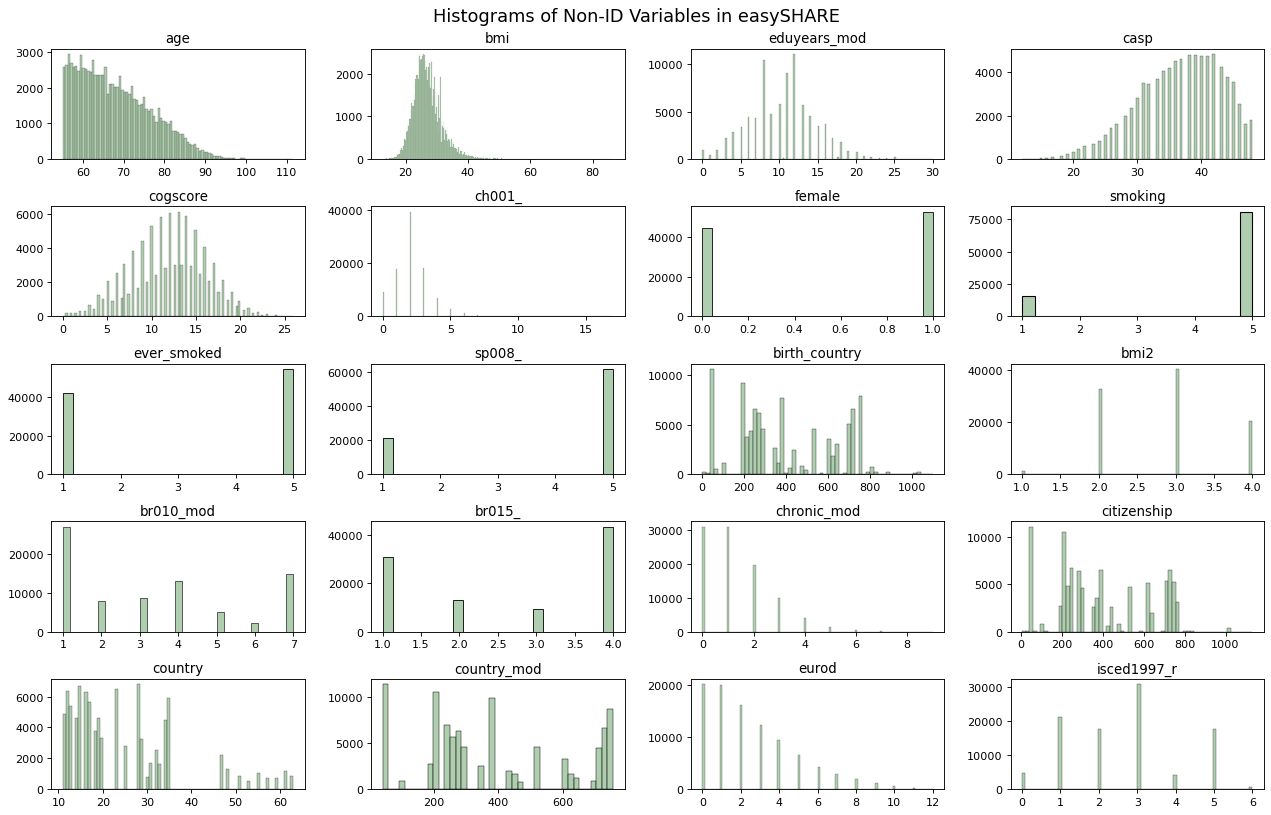

In [35]:
# df.info()   # no missing values
# List of columns per type of variable
id_vars = ['int_year','wave','mergeid']     # ID variables
numerical_vars = ['age','bmi','eduyears_mod','casp','cogscore','ch001_']  # Non-categorical variables
binary_vars = ['female','smoking','ever_smoked','sp008_']     # Binary variables
cat_vars = np.setdiff1d(df.columns,id_vars + numerical_vars + binary_vars).tolist()  # Categorical variables (n>2)
# Explore variable distributions through histograms
non_id_vars = numerical_vars + binary_vars + cat_vars # Get vector of all variables to plot with histograms

# Figure plot area and settings
fig, ax = plt.subplots(figsize = (16, 10))
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])

# For loop to create histograms
for n, col in enumerate(non_id_vars):
    plt.subplot(5, 4, n+1)
    a = sns.histplot(df[col],ax = plt.gca(),color='#95bd95')
    a.set(xlabel=None, ylabel=None)
    a.set_facecolor('white')
    plt.title(col)
plt.tight_layout()
plt.suptitle("Histograms of Non-ID Variables in easySHARE", fontsize=16, y=1.015)

The histograms in easySHARE reveal diverse non-normal distributions, often heavy-tailed or skewed. These deviations from normality can complicate pattern detection for certain algorithms. Considering these characteristics, normalization through Box-Cox transformations is advisable.

Additionally, a notable portion of our features are skewed count or categorical variables, some heavily centered around 0 (*eurod* and *chronic_mod*). Managing these features demands subtlety, particularly addressing outliers and transforming them for more normal-like distributions to facilitate inference with model coefficients.

To comprehend variable peculiarities and determine necessary transformations before modeling, we'll explore boxplots of the features.


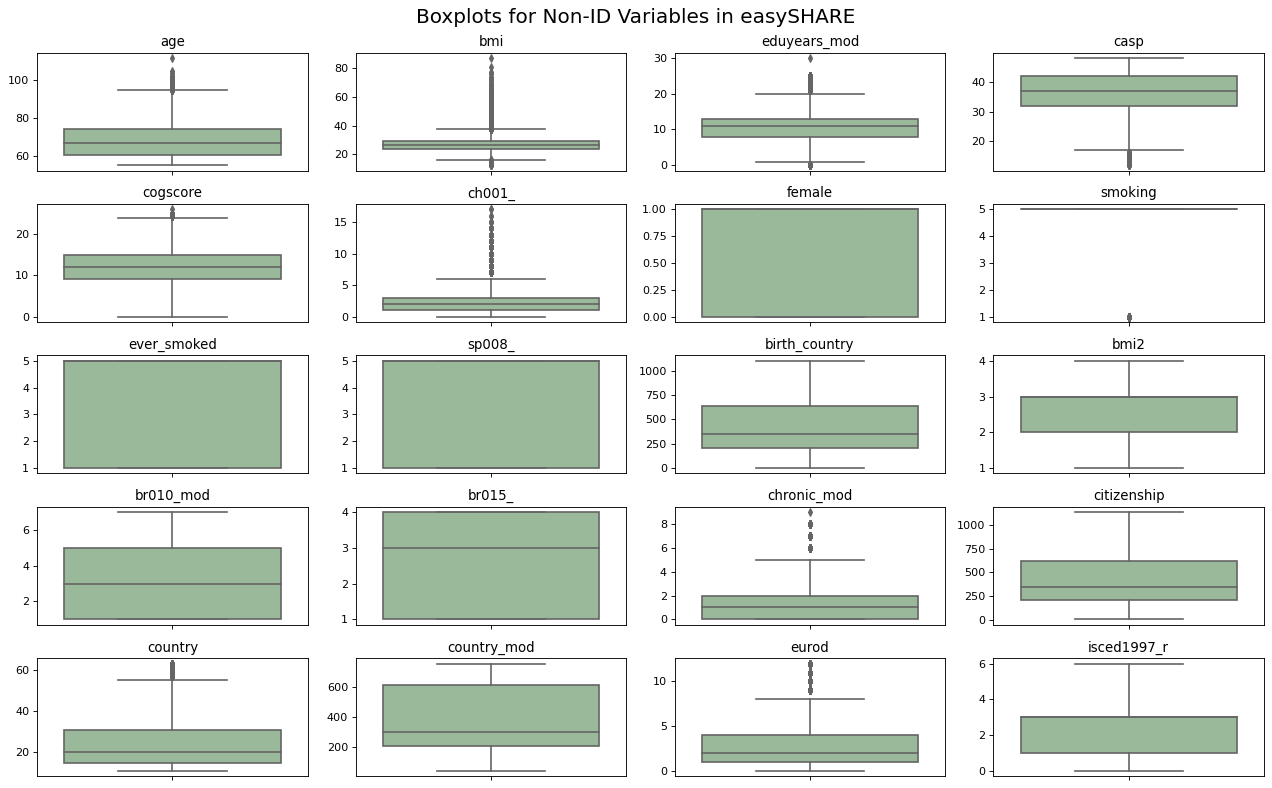

In [6]:
# Generating Box-Plots for Non-ID Variables
fig, axes = plt.subplots(figsize = (16, 10), ncols = 4, nrows=5, sharex = True)
axes = axes.flatten()

for i, ax in enumerate(axes):
    sns.boxplot(y = df[non_id_vars].values[:,i], ax = ax, color='#95bd95') 
    ax.set_title(non_id_vars[i])
    ax.set_ylabel("")
plt.suptitle("Boxplots for Non-ID Variables in easySHARE", fontsize=18)
plt.tight_layout()

Some features in the dataset exhibit numerous outliers, and our suggested outlier treatment varies for these variables:

- *age*: Retaining outliers is crucial for estimating dementia severity, closely linked to age. Removing outliers would hinder our model's ability to predict severity for older individuals, where dementia is more prevalent.

- *bmi*: Despite numerous outliers, each holds valuable information. Instead of discarding them for a smoother distribution, we'll utilize its categorical transformation, *bmi2*, offering a more interpretable prediction model.

- *eurod*: As a categorical depression indicator, removing outliers would eliminate extreme categories (e.g., 'very depressed'), limiting our model's capacity to estimate dementia severity for those significantly affected by depression.

- *casp*: Outliers in this quality of life index, primarily at the lower end, indicate higher dementia severity risk. Consistent with the previous variable, we choose to retain these outliers.

- *eduyears_mod*, *ch001_* and *chronic_mod*: Given these count variables (education years, number of children, and chronic diseases), extremes may not effectively distinguish from upper values (e.g., someone with a PhD and post-Doctoral degree). We recommend handling outliers through winsorization, suitable for skewed counts$^{6}$.

## Data Cleaning

We proceed to cleaning our data in order to explore if winsorization does indeed improve the outliers in these distributions.

In [7]:
# Creating a copy of dataframe where all data cleaning and transformations will be stored
df_transformations = df.copy()
df_transformations = df_transformations.dropna() # Drop the null values

In [8]:
# Winsorizing eduyears_mod, chronic_mod and ch001_
# Finding the 99th (upper bound) and 1st (lower bound) percentiles for each variable to winsorize

# Bounds for years of education
upper_lim_edu = df['eduyears_mod'].quantile(0.99)
lower_lim_edu = df['eduyears_mod'].quantile(0.01)
# Bounds for chronic diseases    
upper_lim_chr = df['chronic_mod'].quantile(0.99)
lower_lim_chr = df['chronic_mod'].quantile(0.01)
# Bounds for number of children
upper_lim_child = df['ch001_'].quantile(0.99)
lower_lim_child = df['ch001_'].quantile(0.01)

# Replacing original variables with winsorized vectors
df_transformations['eduyears_mod'] = np.where(df_transformations['eduyears_mod'] >= upper_lim_edu,
                        upper_lim_edu,
                        np.where(df_transformations['eduyears_mod'] <= lower_lim_edu,
                        lower_lim_edu,
                        df_transformations['eduyears_mod']))

df_transformations['chronic_mod'] = np.where(df_transformations['chronic_mod'] >= upper_lim_chr,
                        upper_lim_chr,
                        np.where(df_transformations['chronic_mod'] <= lower_lim_chr,
                        lower_lim_chr,
                        df_transformations['chronic_mod']))

df_transformations['ch001_'] = np.where(df_transformations['ch001_'] >= upper_lim_child,
                        upper_lim_child,
                        np.where(df_transformations['ch001_'] <= lower_lim_child,
                        lower_lim_child,
                        df_transformations['ch001_']))

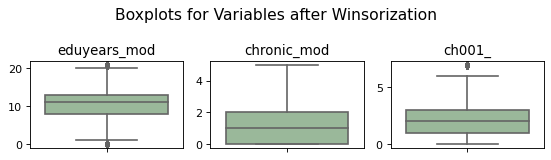

In [9]:
# Generating boxplots after winsorization
winsor_vars = ['eduyears_mod','chronic_mod','ch001_'] # Vector of variables that were winsorized

fig, axes = plt.subplots(figsize = (7, 2), ncols = 3, nrows=1, sharex = True)
axes = axes.flatten()
winsor_vars_values = df_transformations[winsor_vars].values
for i, ax in enumerate(axes):
    sns.boxplot(y = winsor_vars_values[:,i], ax = ax, color='#95bd95') 
    ax.set_title(winsor_vars[i])
    ax.set_ylabel("")
plt.suptitle("Boxplots for Variables after Winsorization", fontsize=14)
plt.tight_layout()

Indeed, winsorizing *eduyears_mod*, *chronic_mod* and *ch001_* with their 99$^{th}$ and 1$^{st}$ percentiles as bounds helped to regularise the outliers for these features. 

## Data Transformation

We will now explore the normality for the standardised version of the numerical features (count and continuous variables) in our dataset.

Text(0.5, 0.98, 'Q-Q Plots of Numerical Variables in easySHARE')

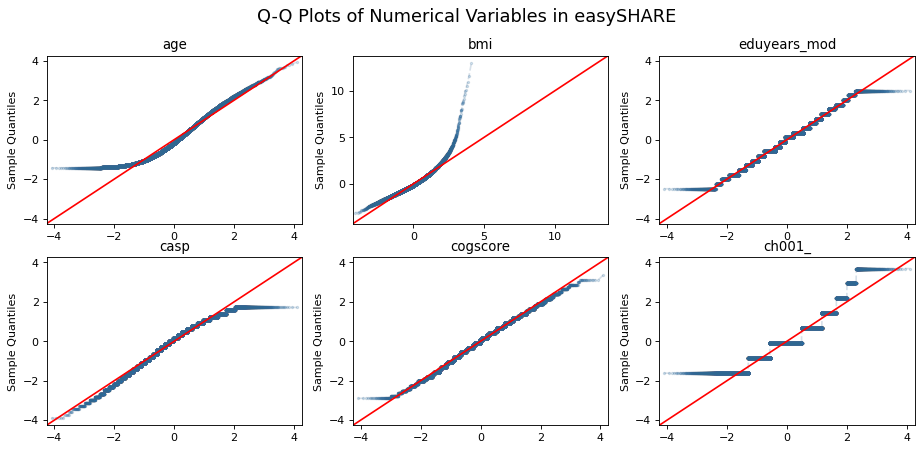

In [36]:
# Q-Q Plot Exploration of Normality for Numerical Variables in easySHARE
# Standardisation of the numerical variables
std_numerical_df = df_transformations[numerical_vars].values
std_numerical_df = pp.StandardScaler().fit_transform(std_numerical_df)
std_numerical_df = pd.DataFrame(std_numerical_df, columns=numerical_vars)

fig, axs = plt.subplots(figsize=(14, 6))
axs.set_frame_on(False)
axs.set_xticks([])
axs.set_xlabel([])
for n, col in enumerate(numerical_vars):
    plt.subplot(2, 3, n+1)
    sm.qqplot(std_numerical_df[col], ax=plt.gca(), line='45', fit=False,
                **{'markersize':2, 'alpha':0.2,'markeredgecolor':'#3a6791',
                'linestyle':'dashed','color':'#3a6791'})
    plt.title(col)
    plt.xlabel('')
fig.suptitle('Q-Q Plots of Numerical Variables in easySHARE', fontsize=16)

Our dataset's numerical features display somewhat skewed normal distributions with variable-dependent fatter/lighter tails than the normal. Notably, *bmi* deviates most from normality, as expected due to earlier identified outliers in its boxplot. Count variables (*ch001_* and *eduyears_mod*) exhibit a step-wise distribution with lower boundaries above normal, accumulating more density (cannot have less than $0$ children or years of education) and some outliers at the higher extreme.

To address skewness and facilitate modeling inference, we'll explore Box-Cox transformations for our numerical variables, seeking the $\lambda$ maximizing the log-likelihood function. Notably, 0.01 will be added to count variables before $\lambda$ optimization, as they have significant density at value $0$, and $\log(0)$ is undefined$^{7}$.

In [11]:
# Finding optimal lambda for non-normal variables.
age_box_, bc_age_param = stats.boxcox(df_transformations['age'].astype(int), lmbda = None)
cs_box_, bc_cs_param = stats.boxcox(df_transformations['cogscore'].astype(float), lmbda = None)
casp_box_, bc_casp_param = stats.boxcox(df_transformations['casp'].astype(float), lmbda = None)
bmi_box_, bc_bmi_param = stats.boxcox(df_transformations['bmi'].astype(float), lmbda = None)
eduyrs_box_, bc_eduyrs_param = stats.boxcox((df_transformations['eduyears_mod']+0.01).astype(float), lmbda = None)
ch001_box_, bc_ch001_param = stats.boxcox((df_transformations['ch001_']+0.01).astype(float), lmbda = None)
best_lambdas = [bc_age_param, bc_cs_param, bc_bmi_param, bc_casp_param, bc_eduyrs_param, bc_ch001_param]

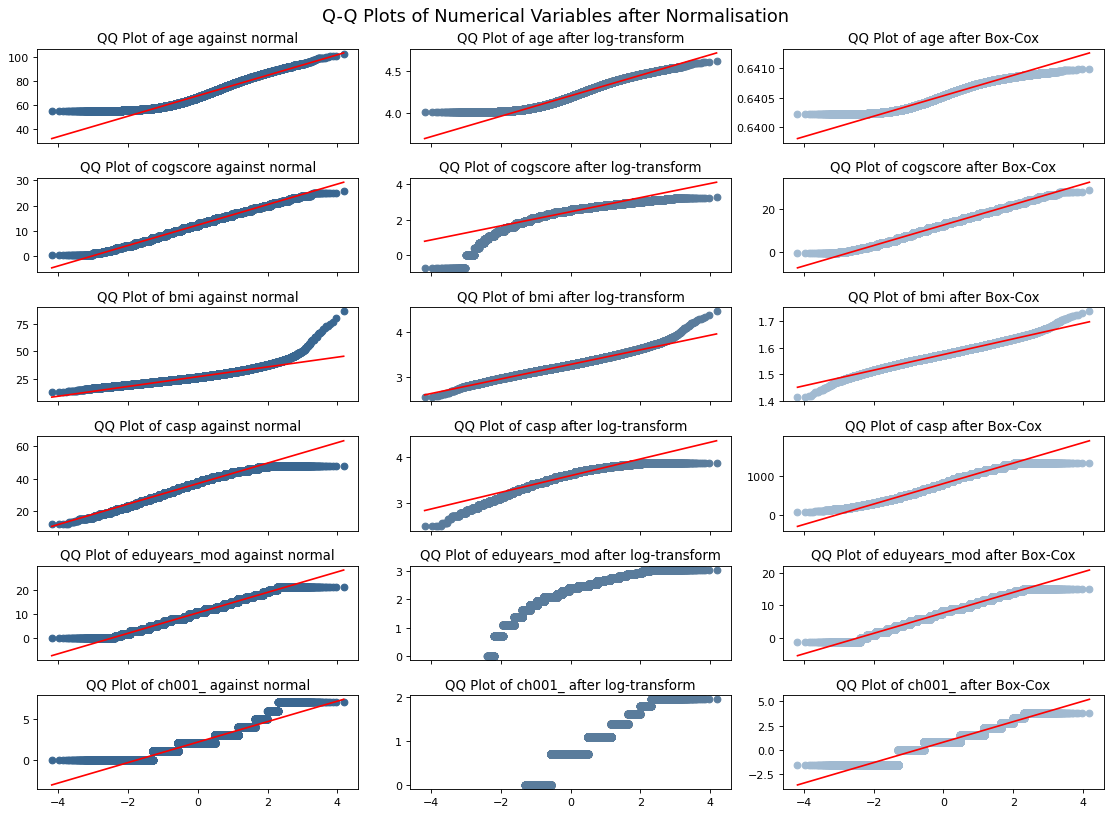

In [37]:
# Adapted from Feature Engineering for Machine Learning principles and techniques for data scientists
boxcox_list = ['age', 'cogscore', 'bmi', 'casp', 'eduyears_mod', 'ch001_'] # List of variables to which we apply Box-Cox transformations

# Dataframe with columns we apply Box-Cox transformation to
boxcox_df = df_transformations[boxcox_list]
df_trans_copy = df_transformations[non_id_vars]

# Graph to compare QQ Plots pre and post log-transformation using optimal lambda
fig2, axs = plt.subplots(6, 3, figsize=(14,10), sharex=True)
# For loop to create 3 comparison plots for each variable
for i in range(len(axs)):
    # QQ Plot of Original Variable Data
    prob1 = stats.probplot(boxcox_df[boxcox_list[i]].astype(float), dist=stats.norm, 
    plot=axs[i][0])     # Plot original data 
    axs[i][0].set_xlabel('')
    axs[i][0].set_ylabel('') 
    axs[i][0].set_title(f'QQ Plot of {boxcox_list[i]} against normal') 
    axs[i][0].get_lines()[0].set_markerfacecolor('#3a6791')
    axs[i][0].get_lines()[0].set_markeredgecolor('#3a6791')
    
    # QQ Plot of Log-Transformed Variable Data
    var_logtrans_ = stats.boxcox(boxcox_df[boxcox_list[i]].astype(float), lmbda=0.)
    prob2 = stats.probplot(var_logtrans_, dist=stats.norm, plot=axs[i][1]) 
    axs[i][1].set_xlabel('') 
    axs[i][1].set_ylabel('') 
    axs[i][1].set_title(f'QQ Plot of {boxcox_list[i]} after log-transform')
    axs[i][1].get_lines()[0].set_markerfacecolor('#5a7c9c')
    axs[i][1].get_lines()[0].set_markeredgecolor('#5a7c9c')

    # QQ Plot of Box-Cox Transformed Variable Data
    var_boxcox_ = stats.boxcox(boxcox_df[boxcox_list[i]].astype(float), lmbda=best_lambdas[i])
    prob3 = stats.probplot(var_boxcox_, dist=stats.norm, plot=axs[i][2]) 
    axs[i][2].set_xlabel('') 
    axs[i][2].set_ylabel('') 
    axs[i][2].set_title(f'QQ Plot of {boxcox_list[i]} after Box-Cox')
    axs[i][2].get_lines()[0].set_markerfacecolor('#a1bad1')
    axs[i][2].get_lines()[0].set_markeredgecolor('#a1bad1')
plt.tight_layout()
fig2.suptitle('Q-Q Plots of Numerical Variables after Normalisation', fontsize=16, y=1.015)
plt.show()

From the normalisation of these variables, we can identify that the feature *bmi* has significantly benefitted from the transformation. In general, log-transformation was not beneficial for any of the variables, and for the rest of the numerical features, Box-Cox transformation using their optimal $\lambda$ did not significantly improve the normality (they were visibly close enough to a normal).

To implement the last steps of our feature engineering process, we will proceed to transform the categorical variables *bmi2*, *br010_mod* and *br015_*, which currently have categories in numerical scales, to string variables with the interpretation of each category to have them in a format that allows for OneHotEncoding.

In [13]:
# Replacing smoking value 5 (non-smoker) for 0.
for i in binary_vars:
    df_transformations[i] = np.where(df_transformations[i] == 5, 0,df_transformations[i])

bmi2_vals = ['underweight','normal','overweight','obese']
br010_vals = ['no_drink','less1mo_drink','cple1mo_drink','cple1wk_drink',
            '4wk_drink','6wk_drink','daily_drink']
br015_vals = ['more1wk_act','1wk_act','mnthly_act','hardly_act']

df_transformations['bmi2'] = np.where(df_transformations['bmi2'].astype(int)==1,bmi2_vals[0],
                        np.where(df_transformations['bmi2'].astype(int)==2,bmi2_vals[1],
                        np.where(df_transformations['bmi2'].astype(int)==3,bmi2_vals[2],bmi2_vals[3])))

df_transformations['br015_'] = np.where(df_transformations['br015_'].astype(int)==1,br015_vals[0],
                        np.where(df_transformations['br015_'].astype(int)==2,br015_vals[1],
                        np.where(df_transformations['br015_'].astype(int)==3,br015_vals[2],br015_vals[3])))

df_transformations['br010_mod'] = np.where(df_transformations['br010_mod'].astype(int)==1,br010_vals[0],
                        np.where(df_transformations['br010_mod'].astype(int)==2,br010_vals[1],
                        np.where(df_transformations['br010_mod'].astype(int)==3,br010_vals[2],
                        np.where(df_transformations['br010_mod'].astype(int)==4,br010_vals[3],
                        np.where(df_transformations['br010_mod'].astype(int)==5,br010_vals[4],
                        np.where(df_transformations['br010_mod'].astype(int)==6,br010_vals[5],br010_vals[6]))))))

## Data Partitioning

We proceed to splitting the data into training and testing sets before exploring the correlations between the variables in the dataset.

In [14]:
# Set a seed for reproducibility of results
rng = np.random.seed(21701)
features = ['age','bmi','eduyears_mod','casp','ch001_','female',
            'smoking','ever_smoked','sp008_','bmi2','br010_mod',
            'br015_','chronic_mod','eurod','isced1997_r'] # First split off features and targets

X = df_transformations[features]
y = df_transformations['cogscore']
# We shuffle the data so the countries get mixed up
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng)

After splitting our data into training and testing sets, we examine the correlation matrix of observed features. Considering feature correlations is crucial before modeling for various reasons. It aids in mitigating collinearity by identifying highly correlated features that could impact model accuracy if both are used. Correlation also helps pinpoint features highly correlated and potentially predictive of our target variable, *cogscore*.

Text(0.5, 0.95, 'Heatmap of Non-ID Variables in easySHARE')

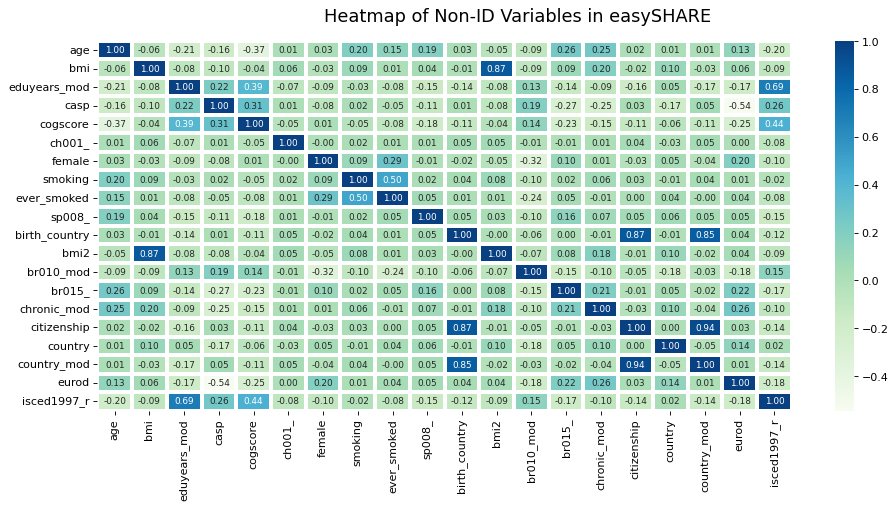

In [15]:
# Plot a heat map to check if any of the features are correlated
rcParams['figure.figsize'] = 14,6
sns.heatmap(df_trans_copy.corr(),cmap="GnBu", annot = True,
            fmt = '.2f',  linewidths = 2, annot_kws={"size": 8})
plt.suptitle('Heatmap of Non-ID Variables in easySHARE',fontsize=16,y=0.95)


As expected, *birth_country*, *country_mod* and *citizenship* have a high positive correlation; as do *eduyears_mod* and *isced1997_r* (ISCED-97 coding of education level), and *bmi* and *bmi2*. This serves as a reminder to choose only one of the representation of these demographic factors (continuous vs categorical). Additionally, *eurod* (depression level) and *casp* (quality of life) seem to have medium correlation. Other than this, factors do not seem to have high correlation amongst themselves, thus, it is not evident from the start that any of the other variables could bring collinearity issues to the models. Moreover, we can observe that there is some correlation ($\geq$ $\lvert0.2\rvert)$) between our dependent variable of interest, *cogscore*, and the following variables:

- **Education**: *isced1997_r* and *eduyears_mod*
- **Depression**: *eurod*
- **Physical activity**: *br015_*
- **Age**: *age*
- **Quality of life**: *casp*

We will proceed to investigate the scatter plots between *cogscore* and each of these variables in order to identify possible model functional forms.

Text(0.5, 1.02, 'Scatter Plot of Variables Correlated to Cognitive Score')

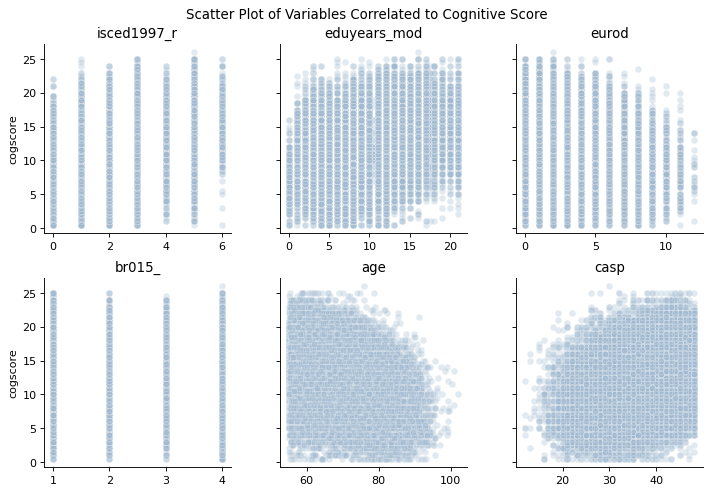

In [16]:
# "Pairplot" equivalent
vars_corr = ['isced1997_r','eduyears_mod','eurod',
                      'br015_','age','casp']
vars_corr_cs = vars_corr + ['cogscore']                      
corr_df = df_trans_copy[vars_corr_cs]

# Creating Facet Grid
g = sns.FacetGrid(pd.DataFrame(vars_corr), col=0, col_wrap=3, sharex=False)
# Plotting scatterplots
for ax, varx in zip(g.axes, vars_corr):
    sns.scatterplot(data=corr_df, x=varx, y="cogscore", ax=ax,alpha=0.3,color='#a1bad1').set_title(varx)
    ax.set_xlabel("")
plt.suptitle('Scatter Plot of Variables Correlated to Cognitive Score', y=1.02)

At first glance, no obvious functional forms are apparent between the dataset's variables and *cogscore*. However, we see an inverse relationship between *age* and *cogscore* (as we would expect cognitive score to lower as people age), and a direct relationship between *casp*/*eduyears_mod* and *cogscore* (as it to be expected: on average higher cognitive score for people with higher life quality and education). Thus, taking note of the results of our correlation matrix and scatter plots, we will proceed to the modelling stage of the study.

# Model Fitting and Tuning


Post feature engineering, we initiate model construction. Through data exploration, we identified features with high correlation, allowing us to select only one representation. Also, features highly correlated with our target variable, *cogscore*, are crucial for inclusion. As scatterplots provided no further insight on *cogscore* correlation, we concentrate on features highlighted in the correlation matrix and literature:

- obesity
- smoking
- education
- drinking behavior
- physical activity level
- quality of life
- age

## Baseline Model

In [17]:
# Baseline features
baseline_features = ['eduyears_mod', 'casp','age','eurod','smoking']
X_train_bs, X_test_bs = X_train[baseline_features], X_test[baseline_features]
# Setting up the pipeline for the baseline model
num_pre = Pipeline([
    ("num_scale", StandardScaler())])
baseline_pipe = Pipeline([
    ("pre_processing", ColumnTransformer([("numerical", num_pre, [0,1,2,3]),
                                         ("binary", "passthrough", [4])])),
    ("model", LinearRegression())])

baseline_model = baseline_pipe.fit(X_train_bs,y_train)

coef_col_names_bs=['intercept','eduyears_mod', 'casp','age','eurod','smoking']
coefs0 = pd.DataFrame([get_coefs(baseline_model)],
                        columns=coef_col_names_bs).transpose()
coefs0.rename(columns={coefs0.columns[0]: "Coefficients"}, inplace = True)

In [114]:
# Calculating statistical significance of baseline coefficients
params = get_coefs(baseline_model)
predictions = baseline_model.predict(X_train_bs)

new_X = pd.DataFrame({"Constant":np.ones(len(X_train_bs))}).join(pd.DataFrame(X_train_bs.reset_index(drop=True)))
MSE = (sum((y_train - predictions)**2))/(len(new_X) - len(new_X.columns))
var_b = MSE * (np.linalg.inv(np.dot(new_X.transpose(), new_X)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/sd_b

p_values = [2 * (1 - stats.t.cdf(np.abs(i), (len(new_X) - len(new_X.columns)))) for i in ts_b]

sd_b = np.round(sd_b, 3)
ts_b = np.round(ts_b, 3)
p_values = np.round(p_values, 3)
params = np.round(params, 4)

bs_summary = pd.DataFrame()
bs_summary["Factors"], bs_summary["Coefficients"], bs_summary["SDE"], bs_summary["T-Values"], bs_summary["P-Values"] = [coef_col_names_bs, params, sd_b, ts_b, p_values]
bs_summary = bs_summary.set_index(['Factors'])

display(Latex(bs_summary.to_latex()))
## NOTE: Confirmed the coefficients are equal to the sklearn Linear Regression ran above.

<IPython.core.display.Latex object>

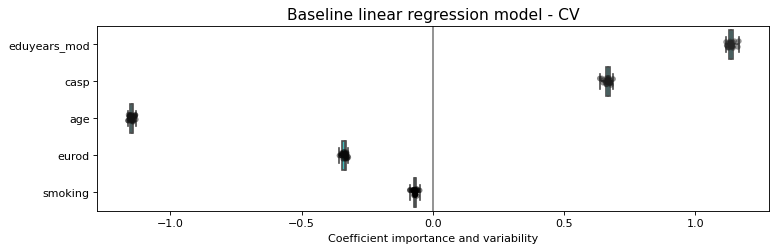

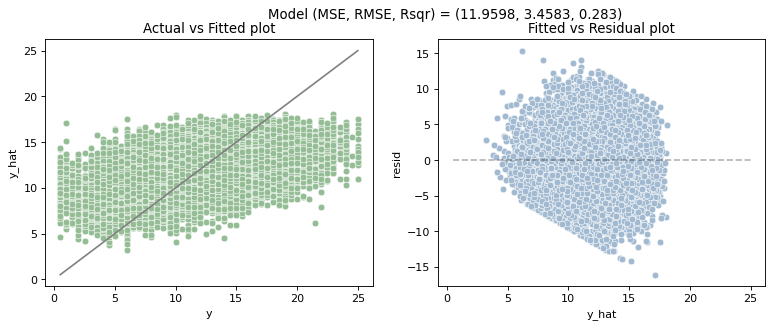

(11.9598, 3.4583, 0.283)

In [19]:
# Coefficient Variability Analysis
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)
cv_model = cross_validate(baseline_model,X_train_bs,y_train,cv=cv,return_estimator=True,n_jobs=2)

coefs = pd.DataFrame(
    [est[-1].coef_ * est[:-1].transform(X_train_bs.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X_train_bs, y_train))],
    columns=baseline_features)

plt.figure(figsize=(14, 3))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance and variability")
plt.title("Baseline linear regression model - CV",fontsize=14)
plt.subplots_adjust(left=0.3)
# Model fit
baseline_MSE, baseline_RMSE, baseline_R2 = model_fit(baseline_model, X_train_bs, y_train, plot = False)
model_fit(baseline_model, X_train_bs, y_train, plot = True)

In our baseline model, all factors are statistically significant. As expected, more education years, higher quality of life, and the intercept show a positive relationship with cognitive score, indicating lower dementia severity. Conversely, individual age, higher depression, and smoking habits exhibit a negative relationship with cognitive score, indicating a positive association with dementia.

Furthermore, the baseline model achieves an R-squared of $28.3\%$ for the training dataset. However, its plots suggest limited reliability in predicting the relationship between independent variables and the target variable, cogscore. Notably, there's no apparent linear relationship between chosen independent variables and the target variable.

## Further Models

To enhance our model's performance, we employed a Sequential Feature Selector (SFS) algorithm from the easySHARE database. This greedy search algorithm aims to reduce feature dimensions, identifying a subset of the most relevant features for improved computational efficiency and reduced model error. We opted for forward selection of features using mean squared error as the criteria. The SFS model starts with $0$ features, adding the best single feature in each iteration to minimize the mean squared error. Once the minimum is reached, the algorithm concludes, providing a vector of selected features.

In this study, the algorithm selected the following features:

In [115]:
# Sequential Feature Selection
onehot_encoder = OneHotEncoder(drop='first')
encoder = ColumnTransformer([
    ("num", "passthrough", [0,1,2,3,4,5,6,7,8,12,13,14]), # pass through all columns with numerical values 
    ("cat", onehot_encoder, [9,10,11])]) # apply the onehot_encoder to the last column

names_post_encoding = ['age','bmi','eduyears_mod','casp','ch001_','female',
                       'smoking','ever_smoked','sp008_','normal','overweight',
                       'obese','less1mo_drink','cple1mo_drink','cple1wk_drink',
                       '4wk_drink','6wk_drink','daily_drink','1wk_act','mnthly_act',
                       'hardly_act','chronic_mod','eurod','isced1997_r']

X_train_1hot = encoder.fit_transform(X_train)
X_test_1hot = encoder.fit_transform(X_test)

sfs = SequentialFeatureSelector(LinearRegression(),
                                direction='forward',
                                scoring='neg_mean_squared_error')
sfs_selector = sfs.fit(X_train_1hot, y_train)
selected_columns = sfs_selector.get_support()

X_train_best = sfs_selector.transform(X_train_1hot) # Creating subset of training data with selected columns
X_test_best = sfs_selector.transform(X_test_1hot) # Creating subset of testing data with selected columns

# Columns selected by Sequential Feature Selector
selected_cols_index = (selected_columns*1).tolist()
selected_features = [x for i, x in enumerate(names_post_encoding) if selected_cols_index[i]]
selected_features_df = pd.DataFrame(selected_features,columns=['Selected Features'])
display(Latex(selected_features_df.to_latex()))

<IPython.core.display.Latex object>

In line with literature (*Lancet 2017 and 2020*), the SFS algorithm selected indicators of age, education, smoking habits, social contact, obesity, physical activity and other chronic diseases as significant factors to predict dementia severity. Moreover, it selected *casp*, a life quality indicator which in this study's data exploration phase was shown to have a $-0.54$ correlation with depression indicators, thus there is some merit to including only the best predictor of these two variables in the models for dementia severity.
 
The previously listed features are used as the independent variables in the rest of our evaluated models, which include:
- **Polynomial Regression**: This model was used to detect possible non-linear relationships between the factors and dementia severity. A grid search was performed to determine the best fitting polynomial degree, resulting in a second-degree polynomial model. 

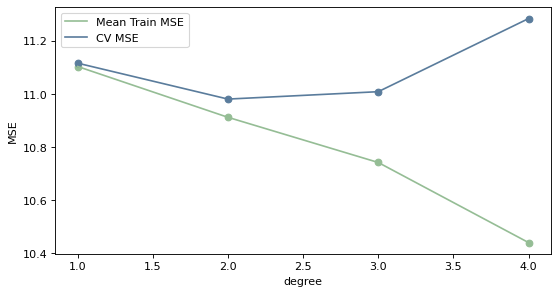

In [21]:
pf = PolynomialFeatures(include_bias=False)
poly_pipe = Pipeline([("poly", pf),("model", LinearRegression())]) # Overall ML pipeline
parameters = {'poly__degree': np.arange(1, 5, 1)} # Parameters for grid search

kf = KFold(n_splits = 5, shuffle = True, random_state=rng)
grid_search = GridSearchCV(poly_pipe, parameters, cv = kf, scoring = 'neg_mean_squared_error', return_train_score=True).fit(X_train_best, y_train)
pd.DataFrame(grid_search.cv_results_)

degree = np.arange(1, 5, 1)
fig, ax = plt.subplots(figsize=(8,4), ncols=1, nrows=1)
plt.scatter(degree,-grid_search.cv_results_['mean_train_score'], color='#95bd95')
plt.plot(degree,-grid_search.cv_results_['mean_train_score'], color='#95bd95', label='Mean Train MSE')
plt.scatter(degree,-grid_search.cv_results_['mean_test_score'], color='#5a7c9c')
plt.plot(degree,-grid_search.cv_results_['mean_test_score'], color='#5a7c9c', label='CV MSE')
ax.legend()
ax.set_xlabel('degree')
ax.set_ylabel('MSE')
plt.show()

poly_MSE, poly_RMSE, poly_R2 = model_fit(grid_search.best_estimator_, X_train_best, y_train, plot=False)

- **Ridge Regression**: This model was chosen to contemplate the possibility that some of the features selected could still have coefficients that could be shrinked near to zero, which would allow us to more clearly identify which are the factors that policy-makers must focus on with the highest priority.

In [22]:
alphas = np.linspace(0, 20, num=150)  # Grid of tuning parameters
ridge_pipe = make_pipeline(StandardScaler(),Ridge()) #Pipeline
cv = KFold(5, shuffle=True, random_state=rng) # CV strategy
# Grid search
gs = GridSearchCV(ridge_pipe,param_grid={'ridge__alpha': alphas},cv=cv,scoring="neg_mean_squared_error")
gs.fit(X_train_best, y_train)

ridge_MSE, ridge_RMSE, ridge_R2 = model_fit(gs.best_estimator_, X_train_best, y_train, plot=False)

- **Elastic Net Regression**: We also evaluated this model with the same goal of the *Ridge Regression*, but taking into consideration it would output some of the coefficients as zero, making the most relevant features even clearer.

In [39]:
alpha_val = np.arange(1, 100, 1)
MSE = []
for alpha in alpha_val:
    r = make_pipeline(StandardScaler(),ElasticNet(alpha = alpha, random_state=rng)).fit(X_train_best, y_train)
    MSE.append(model_fit(r, X_train_best, y_train)[0])

best_alpha_EN = make_pipeline(StandardScaler(),ElasticNet(alpha = np.argmin(MSE), random_state=rng)).fit(X_train_best, y_train)
EN_MSE, EN_RMSE, EN_R2 = model_fit(best_alpha_EN, X_train_best, y_train,plot=False)


- **Random Forest Regression**: Given the Random Forest algorithm's known strength of handling datasets with continuous and categorical variables, the present study evaluated using this model seeking to improve prediction accuracy with the algorithm's "wisdom of the crowds" approach.

In [24]:
rand_forest_reg = RandomForestRegressor(max_depth=2, random_state=rng)
rand_forest_reg.fit(X_train_best, y_train)
RF_MSE, RF_RMSE, RF_R2 = model_fit(rand_forest_reg, X_train_best, y_train, plot=False)

- **Histogram-Based Gradient Boosting Regression (HBGB)**: Adopting a histogram-based gradient boosting regression allows us to harness the predictive strength of multiple weak learners within the gradient boosting (GB) algorithm. This approach sequentially builds simple models to reduce errors from the previous one. HBGB, a machine learning technique, accelerates training by leveraging histograms and integer-based data structures$^{8}$, ensuring computational efficiency for our GB regression.

Our final choice is the HBGB Regression, emphasizing predictive power to identify key factors for dementia severity, aiding policymakers. We conduct a grid search with K-Fold cross-validation (5 folds with shuffling) to determine optimal learning and tree parameters. Subsequently, we fit the model using the training dataset features selected by the SFS algorithm.

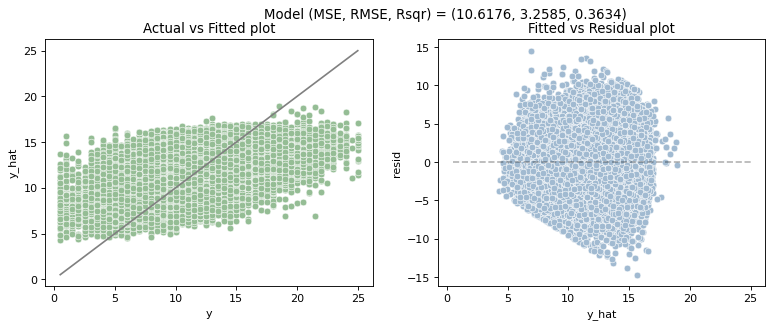

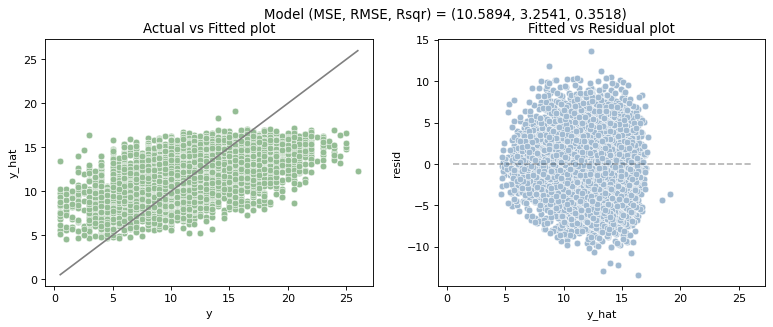

(10.5894, 3.2541, 0.3518)

In [25]:
#  Histogram-Based Gradient Boosting Regression
gb_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler for feature scaling
    ('hist_gb', HistGradientBoostingRegressor(random_state=rng))])  # HistGradientBoostingRegressor for regression
gb_reg = gb_pipeline.fit(X_train_best, y_train)

# Define cross-validation strategy, for example, KFold with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=rng)
# Define the parameter grid to search
param_grid = {'scaler__with_mean': [True, False],  # StandardScaler parameter
    'scaler__with_std': [True, False],   # StandardScaler parameter
    'hist_gb__learning_rate': [0.01, 0.1, 0.2],
    'hist_gb__max_iter': [100, 200, 300],
    'hist_gb__max_depth': [3, 5, 7],
    'hist_gb__min_samples_leaf': [1, 5, 10],
    'hist_gb__max_leaf_nodes': [15, 31, 50]}

# # Perform grid search with cross-validation
grid_search = GridSearchCV(gb_reg, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_best, y_train)
# Best Parameters: {'hist_gb__learning_rate': 0.1, 'hist_gb__max_depth': 7, 'hist_gb__max_iter': 100, 'hist_gb__max_leaf_nodes': 15, 'hist_gb__min_samples_leaf': 5, 'scaler__with_mean': True, 'scaler__with_std': True}
# Best Negative Mean Squared Error: 0.3456750744329497

HGB_MSE, HGB_RMSE, HGB_R2 = model_fit(grid_search.best_estimator_, X_train_best, y_train, plot=False)
model_fit(grid_search.best_estimator_, X_train_best, y_train, plot=True)
model_fit(grid_search.best_estimator_, X_test_best, y_test, plot=True)

In [26]:
y_pred_baseline = baseline_model.predict(X_test_bs)
y_pred_gradboost = gb_reg.predict(X_test_best)
# Wilcoxon signed-rank test (non-parametric alternative)
statistic, p_value_w = wilcoxon(y_pred_gradboost - y_pred_baseline)
print("Wilcoxon signed-rank test p-value for difference of predictions of baseline and HBGB:", round(p_value_w,4))

Wilcoxon signed-rank test p-value for difference of predictions of baseline and HBGB: 0.0004


The histogram-based gradient boosting (HBGB) regression substantially improves on the MSE ($-1.27$, $-11\%$) and R-squared ($+0.082$, $+29\%$) versus this study's baseline model. Furthermore, when performing the Wilcoxon signed-rank statistical test, the *p-value* rejects the null hypothesis that the predicted cognitive scores are the same for the baseline and the HBGB models. With this we can conclude that these models produce statistically different results, hence we can expect that the difference in MSE and R-squared between these models is also statistically different from zero (there exists statiscal significance in the improved model performance of HBGB versus our baseline model).

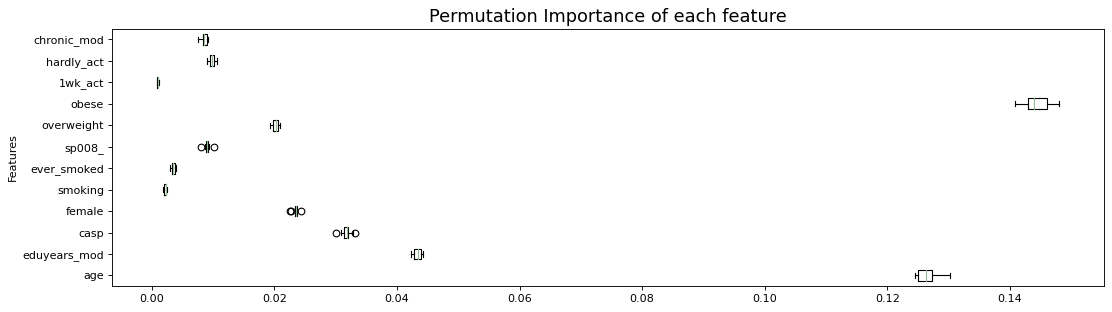

In [27]:
rf = grid_search.best_estimator_.fit(X_train_best,y_train)
result = permutation_importance(rf, X_train_best, y_train, n_repeats=10, random_state=0, n_jobs=-1)
fig, ax = plt.subplots(figsize=(14, 4))
box_plot = ax.boxplot(result.importances.T, vert=False, labels=selected_features)
for median in box_plot['medians']:
    median.set_color('#95bd95')
ax.set_title("Permutation Importance of each feature",fontsize=16)
ax.set_ylabel("Features")
fig.tight_layout()
plt.show()

Moreover, the coefficient variability analysis we performed earlier with our baseline model is equivalent to analysing feature importance for our HBGB model. Feature importance is *"a model inspection technique that seeks to measure each feature to a fitted model’s statistical performance on a given tabular dataset"*$^{9}$. Particularly, in this case we choose to execute a permutation feature importance analysis, which is performed on the fit of the model on the test data, helping to identify real factor relevance even in cases in which the model may have better performance in training data$^{10}$.

As shown in the visualisation above, in line with the results of our baseline model, age, education and quality of life are among the most important factors to predict dementia severity. Nonetheless, in our final model we can identify a remarkable significance of an additional feature, which takes the position of the second most relevant predictor for dementia severity: *obesity*.

In [116]:
model_comparison = {'Model': ['Baseline', 'Polynomial', 'Ridge', 'Elastic Net',
                    'Random Forest','Histogram-Based Gradient Boosting'],
                    'MSE': [baseline_MSE,poly_MSE,ridge_MSE,EN_MSE,RF_MSE,HGB_MSE],
                    'RMSE':[baseline_RMSE,poly_RMSE,ridge_RMSE,EN_RMSE,RF_RMSE,HGB_RMSE],
                    'R-Squared':[baseline_R2,poly_R2,ridge_R2,EN_R2,RF_R2,HGB_R2]}  
model_comparison = pd.DataFrame(model_comparison)  
model_comparison=model_comparison.set_index('Model')
model_comparison.to_latex()

<IPython.core.display.Latex object>

In comparing the models evaluated, the histogram-based gradient boosting regression outperforms others, exhibiting lower MSE and higher R-Squared. Notably, performing a grid search on this model proves computationally demanding. Considering limited computational resources, exploring a polynomial model with degree $2$ may be worthwhile. Despite being computationally more economical, it closely approaches the performance of HBGB regression. Therefore, there exists a tradeoff between predictive accuracy and computational power, acknowledging a limitation in this study's model choice.

# Discussion & Conclusions

This study aimed to uncover dementia severity risk factors in the European Union, providing insights for policymakers. Utilizing easySHARE data, a simplified dataset from the Survey of Health, Ageing and Retirement in Europe (SHARE), we evaluated various machine learning models (linear regression, polynomial, ridge, elastic net, random forest, and histogram-based gradient boosting regressions). The chosen predictive model, Histogram-Based Gradient Boosting (HBGB) Regression, outperformed others, increasing R-squared from $28.2\%$ to $36.5\%$.

The moderate predictive power may stem from easySHARE combining different SHARE survey waves, potentially missing evolving risk factor effects over time. Restructuring studies as classification problems with logistic regressions may offer higher predictive power for dementia prevalence. Additionally, despite superior performance in terms of R-squared and MSE, the HBGB regression is computationally expensive for cross-validation and lacks coefficients for straightforward inference on the size and direction of effect of the risk factors.

The main takeaways from this model can be summed up in the following points:

- Age is the most significant factor when predicting dementia severity, given ageing deteriorates individuals' cognitive abilities. This could suggest that policies targeted to maintain the productivity and engagement of elderly people in society would be beneficial as a prevention mechanism for dementia severity.

- The second most relevant risk factor for dementia severity is obesity. It is important to note that an increasing weight will not necessarily increase the probabilities that an individual gets more severe dementia as long as certain thresholds of weight aren't crossed. Weight begins to be relevant as a risk factor when individuals are overweight or obsese. This points to the fact that policies should be targeted to avoid obesity, which is in line with the fact that physical activity level was also mildly relevant for the model's predictive power.

- Another pertinent factor detected by our model was quality of life. This particular variable reflects people's perception on their control, autonomy, pleasure and self-realization. Although this is quite a general factor and does not necessarily translate to specific public policy recommendations, it is worth noting that it gives policymakers the hope that in working towards a more inclusive society with basic coverage for human rights (health, education, recreation spaces, etc.), they are also working to reduce overall dementia severity.

- Finally, it is significant to address that women tend to have worse dementia severity than males. This distinction must be taken into consideration at the time of policymaking, seeking to ensure that female populations are being adequately targeted by the policies, and contemplating possible extra measure for this segment of the population.

Incorporating these risk factors into policymaking can reshape dementia statistics, ensuring a better future. As a result, this study encourages the European Union to act on dementia, fostering higher life quality for both present and future generations.

# References

***Dataset:*** Börsch-Supan, A. & S. Gruber (2022): easySHARE. Release version: 8.0.0. SHARE-ERIC. Dataset. doi: 10.6103/SHARE.easy.800.

$^{1}$ "World Population Prospects 2022, Summary of Results", United Nations, accessed February 29, 2024, *https://www.un.org/development/desa/pd/sites/www.un.org.development.desa.pd/files/wpp2022_summary_of_results.pdf*.

$^{2}$ "Ageing and Health", World Health Organization, accessed February 29, 2024, *https://www.who.int/news-room/fact-sheets/detail/ageing-and-health#:~:text=Every%20country%20in%20the%20world,in%202020%20to%201.4%20billion.*.

$^{3}$ "Dementia", World Health Organization, accessed February 29, 2024, *https://www.who.int/news-room/facts-in-pictures/detail/dementia*.

$^{4}$ "Dementia", World Health Organization, accessed February 29, 2024, *https://www.who.int/news-room/facts-in-pictures/detail/dementia*.

$^{5}$ Page 123, Feature Engineering and Selection, 2019, accessed March 5, 2024, *https://shorturl.at/mCKNX*.

$^{6}$ "Avoid Mistakes in Machine Learning Models with Skewed Count Data", Medium, accessed March 4, 2024, *https://medium.com/p/e3512b94d745*. 

$^{7}$ "Avoid Mistakes in Machine Learning Models with Skewed Count Data", Medium, accessed March 4, 2024, *https://medium.com/p/e3512b94d745*. 

$^{8}$ "A Faster Ensemble Model Method in Sklearn: Histogram-Based Gradient Boosting", Medium, accessed March 8, 2024, *https://medium.com/chat-gpt-now-writes-all-my-articles/a-faster-ensemble-model-method-in-sklearn-histogram-based-gradient-boosting-7033ff170bc0*.

$^{9}$ "Permutation feature importance", Scikit-learn.org, accessed March 9, 2024, *https://scikit-learn.org/stable/modules/permutation_importance.html*.

$^{10}$ "Permutation importance vs impurity-based feature importance", Medium, accessed March 9, 2024, *https://medium.com/@syoussefi600/permutation-importance-vs-impurity-based-feature-importance-1c1a8d027479*.

In [119]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project1.ipynb

[NbConvertApp] Converting notebook project1.ipynb to pdf
[NbConvertApp] Writing 1102442 bytes to project1.pdf
